In [47]:
import glob
import mne
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE


In [48]:
import os
import numpy as np

# Download fsaverage files
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = os.path.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = os.path.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


In [49]:
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

In [50]:
lobe_map = {"Frontal":{
                "frontalpole":"FP",
                "medialorbitofrontal":"MO",
                "lateralorbitofrontal":"LO",
                "paracentral":"ParaC",
                "parsopercularis":"POp",
                "parsorbitalis":"POr",
                "parstriangularis":"PT",
                "precentral": "PreC",
                "rostralanteriorcingulate":"RAC",
                "rostralmiddlefrontal":"RMF",
                "superiorfrontal":"SF",
                "caudalanteriorcingulate":"CACC",
                "caudalmiddlefrontal":"CMF",
            },
            "Parietal":{
                "superiorparietal":"SP",
                "inferiorparietal":"IP",
                "isthmuscingulate":"IC",
                "postcentral":"PG",
                "posteriorcingulate":"PCC",
                "precuneus":"PCUN",
                "supramarginal":"SG",
            },
            "Temporal":{
                "bankssts":"BSTS",
                "entorhinal":"ENT",
                "fusiform":"FUS",
                "middletemporal":"MT",
                "parahippocampal":"PHG",
                "superiortemporal": "STG",
                "temporalpole":"TP",
                "transversetemporal":"TTG",
                "inferiortemporal":"ITG",
            },
            "Occipital":{
                "cuneus":"CUN",
                "lateraloccipital":"LOC",
                "lingual":"LNG",
                "pericalcarine":"PCAL",
            },
            "Insula":{
                "insula":"INS"
            }
}
lobe_map_color = {"Frontal": (1,0,0),
                  "Insula": (0,1,0),
                "Temporal": (0,0,1),
                "Parietal": (1, 1,0), 
                 "Occipital": (0,1,1),
}

In [51]:
# params
fs_dir = mne.datasets.fetch_fsaverage(verbose=True)
subjects_dir = os.path.dirname(fs_dir)

labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                            subjects_dir=subjects_dir, verbose=False)
labels.pop(-1) # remove the unknown label
label_names = [label.name for label in labels]

# all functions
# example 1_al_ciplv_theta_1.npy
def parse_filename(filename):
    s = filename.split("_")
    pId = s[0]
    label = s[1]
    method = s[2]
    freq = s[-1].split(".")[0]
    
    return {"pId": pId, "label": label, "method": method, "freq": freq}

def read_file(filename): 
    data = np.load(filename)
    return data

def read_file2(filename): # use for lobe-level
    data = np.load(filename)
    data = data + data.T - np.diag(data.diagonal())
    df_corr = pd.DataFrame(data, columns = label_names, index = label_names)
    df_pair = df_corr.stack().reset_index()
    df_pair.columns = ["source", "target", "value"]
    return df_pair

# get all the files in the folder output/
def get_files(folder, filter = None):
    '''
    filter is a dictionary, has 2 keys: method and freq to filter the files
    '''
    files = glob.glob(os.path.join(folder, "*.npy"))
    ret_files = []
    if filter:
        for f in files:
            # get the filename
            filename = os.path.basename(f)
            f_info = parse_filename(filename)
            # remove epoch 2 if no overlap
            # if f_info["epoch"] == "2":
            #     continue
            if (f_info["method"] == filter["method"]) and (f_info["freq"] == filter["freq"]):
                ret_files.append(f)
    else:
        ret_files = files

    return ret_files

def feature_extraction(data):
    """
    get lower part of diagonal matrix
    """
    data_lower = data[np.tril_indices(data.shape[0], k=-1)]
    return data_lower

def get_lobe(name):
    # get hemisphere and label
    label = name.split("-")[0]
    hemisphere = name.split("-")[1]

    for lobe in lobe_map:
        if label in lobe_map[lobe]:
            return lobe + "-" + hemisphere
    return None

def feature_extraction_lobe_level(data):
    """
    data: pandas frame 3 columns: source, target, value. outputs from read_file2()
    """

    # get the lobe level using the lobe_map
    data["source_lobe"] = data["source"].apply(lambda x: get_lobe(x))
    data["target_lobe"] = data["target"].apply(lambda x: get_lobe(x))

    # average the value for the same lobe
    data = data.groupby(["source_lobe", "target_lobe"]).mean().reset_index()

    return data

0 files missing from root.txt in C:\Users\work\mne_data\MNE-fsaverage-data
0 files missing from bem.txt in C:\Users\work\mne_data\MNE-fsaverage-data\fsaverage


In [52]:
lh_labels = ['lateraloccipital-lh','pericalcarine-lh','cuneus-lh','lingual-lh',
            'inferiorparietal-lh','superiorparietal-lh','precuneus-lh','isthmuscingulate-lh','supramarginal-lh','postcentral-lh','posteriorcingulate-lh',
            'bankssts-lh','fusiform-lh','inferiortemporal-lh','parahippocampal-lh','middletemporal-lh','transversetemporal-lh','superiortemporal-lh','entorhinal-lh','temporalpole-lh',
            'insula-lh',
            'paracentral-lh','precentral-lh','caudalmiddlefrontal-lh','parsopercularis-lh','caudalanteriorcingulate-lh','superiorfrontal-lh','lateralorbitofrontal-lh','parstriangularis-lh','rostralanteriorcingulate-lh','medialorbitofrontal-lh','parsorbitalis-lh','rostralmiddlefrontal-lh','frontalpole-lh']
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

new_order = []
new_order.extend(lh_labels[::-1])  # reverse the order
new_order.extend(rh_labels)

In [53]:
new_order

['frontalpole-lh',
 'rostralmiddlefrontal-lh',
 'parsorbitalis-lh',
 'medialorbitofrontal-lh',
 'rostralanteriorcingulate-lh',
 'parstriangularis-lh',
 'lateralorbitofrontal-lh',
 'superiorfrontal-lh',
 'caudalanteriorcingulate-lh',
 'parsopercularis-lh',
 'caudalmiddlefrontal-lh',
 'precentral-lh',
 'paracentral-lh',
 'insula-lh',
 'temporalpole-lh',
 'entorhinal-lh',
 'superiortemporal-lh',
 'transversetemporal-lh',
 'middletemporal-lh',
 'parahippocampal-lh',
 'inferiortemporal-lh',
 'fusiform-lh',
 'bankssts-lh',
 'posteriorcingulate-lh',
 'postcentral-lh',
 'supramarginal-lh',
 'isthmuscingulate-lh',
 'precuneus-lh',
 'superiorparietal-lh',
 'inferiorparietal-lh',
 'lingual-lh',
 'cuneus-lh',
 'pericalcarine-lh',
 'lateraloccipital-lh',
 'lateraloccipital-rh',
 'pericalcarine-rh',
 'cuneus-rh',
 'lingual-rh',
 'inferiorparietal-rh',
 'superiorparietal-rh',
 'precuneus-rh',
 'isthmuscingulate-rh',
 'supramarginal-rh',
 'postcentral-rh',
 'posteriorcingulate-rh',
 'bankssts-rh',
 'f

In [99]:
# colors for new_order, each lobe has a color
roi_colors = []
for roi in new_order:
    lobe = get_lobe(roi)
    roi_colors.append(lobe_map_color[lobe.split("-")[0]])
roi_colors

[(1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (0, 1, 0),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (0, 1, 1),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (1, 1, 0),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 0, 1),
 (0, 1, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0),
 (1, 0, 0)]

In [54]:
freqs = ['delta', 'theta', 'alpha', 'beta', 'gamma']
method = 'pli'
output_dir_prefix = "output/no_split"
# condition = "al"

In [8]:
lh_labels = ['lateraloccipital-lh','pericalcarine-lh','cuneus-lh','lingual-lh',
            'inferiorparietal-lh','superiorparietal-lh','precuneus-lh','isthmuscingulate-lh','supramarginal-lh','postcentral-lh','posteriorcingulate-lh',
            'bankssts-lh','fusiform-lh','inferiortemporal-lh','parahippocampal-lh','middletemporal-lh','transversetemporal-lh','superiortemporal-lh','entorhinal-lh','temporalpole-lh',
            'insula-lh',
            'paracentral-lh','precentral-lh','caudalmiddlefrontal-lh','parsopercularis-lh','caudalanteriorcingulate-lh','superiorfrontal-lh','lateralorbitofrontal-lh','parstriangularis-lh','rostralanteriorcingulate-lh','medialorbitofrontal-lh','parsorbitalis-lh','rostralmiddlefrontal-lh','frontalpole-lh']
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

In [ ]:
#color list for lh_labels



In [28]:
al_sum = np.zeros((len(labels), len(labels)))
# get all the files
files = glob.glob(f"{output_dir_prefix}/*al*{method}*{freqs[0]}*.npy")
# print(files)
for file in files:
    al_sum += np.load(file)

al_sum = al_sum / len(files)

In [55]:
critical_values = np.load("critical_value.npy")

In [29]:
# make correllation matrix from left triangle part
al_sum = al_sum + al_sum.T - np.diag(al_sum.diagonal())

In [103]:
#critical_values[0][0] First index is the condition: 0 alert/1 fatigue, 
# second index is the frequency: 0 delta/1 theta/2 alpha/3 beta/4 gamma
al_delta = critical_values[1][2]
al_delta.shape

(68, 68)

In [104]:
# make correllation matrix from left triangle part
al_delta2 = al_delta + al_delta.T - np.diag(al_delta.diagonal())

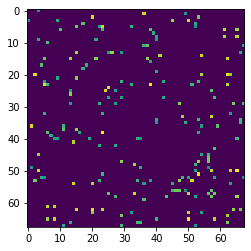

In [79]:
#plot the matrix
import matplotlib.pyplot as plt
plt.imshow(al_delta2)
plt.show()

In [105]:
df_corr = pd.DataFrame(al_delta2, columns = label_names, index = label_names)

In [106]:
df_order = df_corr.reindex(new_order, axis=0).reindex(new_order, axis=1)

In [107]:
df_order

,frontalpole-lh,rostralmiddlefrontal-lh,parsorbitalis-lh,medialorbitofrontal-lh,rostralanteriorcingulate-lh,parstriangularis-lh,lateralorbitofrontal-lh,superiorfrontal-lh,caudalanteriorcingulate-lh,parsopercularis-lh,...,parsopercularis-rh,caudalanteriorcingulate-rh,superiorfrontal-rh,lateralorbitofrontal-rh,parstriangularis-rh,rostralanteriorcingulate-rh,medialorbitofrontal-rh,parsorbitalis-rh,rostralmiddlefrontal-rh,frontalpole-rh
frontalpole-lh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.161513,0.0,0.000000
rostralmiddlefrontal-lh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.243686,0.0,0.0,...,0.0,0.0,0.256977,0.0,0.0,0.0,0.0,0.232292,0.0,0.000000
parsorbitalis-lh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
medialorbitofrontal-lh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.212377
rostralanteriorcingulate-lh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rostralanteriorcingulate-rh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
medialorbitofrontal-rh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
parsorbitalis-rh,0.161513,0.232292,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000
rostralmiddlefrontal-rh,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000


<AxesSubplot:>

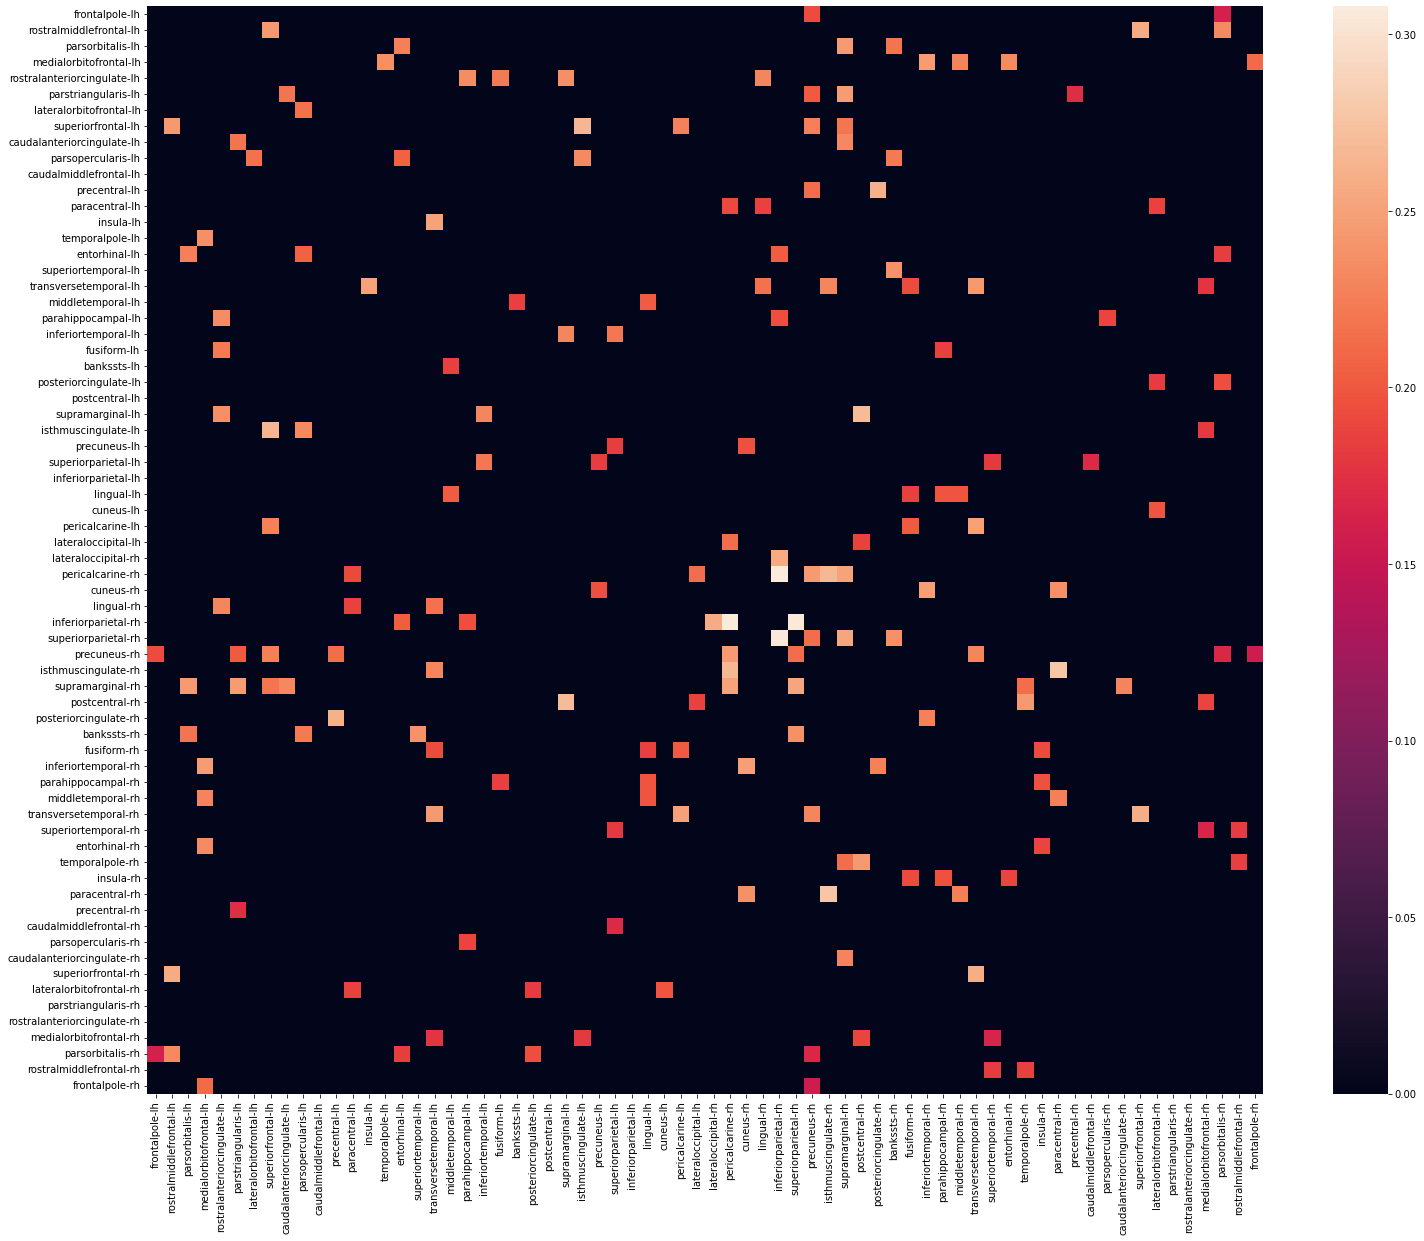

In [108]:
from turtle import color
import seaborn as sns


fig, ax = plt.subplots(figsize=(25,20))

sns.heatmap(df_order, 
            xticklabels=df_order.columns.values,
            yticklabels=df_order.columns.values,
            color=roi_colors, ax=ax)


In [81]:
df_pair = df_corr.stack().reset_index()

In [82]:
df_pair.columns = ['source', 'target', 'connectivity']
df_pair.head()

,source,target,connectivity
0,bankssts-lh,bankssts-lh,0.000000
1,bankssts-lh,bankssts-rh,0.000000
2,bankssts-lh,caudalanteriorcingulate-lh,0.000000
3,bankssts-lh,caudalanteriorcingulate-rh,0.135901
4,bankssts-lh,caudalmiddlefrontal-lh,0.000000


In [83]:
df_order = df_pair.set_index(['source', 'target']).reindex(new_order, level=0).reindex(new_order, level=1).reset_index()
df_order

,source,target,connectivity
0,frontalpole-lh,frontalpole-lh,0.0
1,frontalpole-lh,rostralmiddlefrontal-lh,0.0
2,frontalpole-lh,parsorbitalis-lh,0.0
3,frontalpole-lh,medialorbitofrontal-lh,0.0
4,frontalpole-lh,rostralanteriorcingulate-lh,0.0
...,...,...,...
4619,frontalpole-rh,rostralanteriorcingulate-rh,0.0
4620,frontalpole-rh,medialorbitofrontal-rh,0.0
4621,frontalpole-rh,parsorbitalis-rh,0.0
4622,frontalpole-rh,rostralmiddlefrontal-rh,0.0


In [91]:
# construct the correlation matrix from pairwise data and keep order of current labels
df_corr = df_order.pivot(index='source', columns='target', values='connectivity')


In [84]:
#transform back to correlation matrix
df_corr_order = pd.DataFrame.pivot_table(df_order, index='source', columns='target', values='connectivity', sort=False)

In [85]:
df_corr_order

target,bankssts-lh,bankssts-rh,caudalanteriorcingulate-lh,caudalanteriorcingulate-rh,caudalmiddlefrontal-lh,caudalmiddlefrontal-rh,cuneus-lh,cuneus-rh,entorhinal-lh,entorhinal-rh,...,superiorparietal-lh,superiorparietal-rh,superiortemporal-lh,superiortemporal-rh,supramarginal-lh,supramarginal-rh,temporalpole-lh,temporalpole-rh,transversetemporal-lh,transversetemporal-rh
source,,,,,,,,,,,,,,,,,,,,,
frontalpole-lh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.189291,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
rostralmiddlefrontal-lh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.156789,0.000000,0.0,0.0,0.000000
parsorbitalis-lh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.193267,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
medialorbitofrontal-lh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
rostralanteriorcingulate-lh,0.0,0.0,0.000000,0.0,0.166031,0.14047,0.000000,0.000000,0.0,0.0,...,0.158325,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.141842
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
rostralanteriorcingulate-rh,0.0,0.0,0.208689,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
medialorbitofrontal-rh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.211715,0.0,0.0,0.183579
parsorbitalis-rh,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.000000,0.164657,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
